# Optimal Control: 2D Turbulence

In [1]:
using GeophysicalFlows, JLD2, Interpolations, Statistics, ForwardDiff

dev = CPU()
const n = 512 # grid resolution 
const L = 2π  # domain length    
const t_step = 0.005 # time-step of DNS data
const frame_max=1230 # number of frames

##### Load Velocity Field #####
file = jldopen("../../Data Generation/2d-turb-data.jld")
u_data = file["vel_x"]
v_data = file["vel_y"]
vort_data = file["vort"]
close(file)

##### Interpolations #####
itp_vort = interpolate(vort_data, BSpline(Linear(Periodic())))
itp_u = interpolate(u_data, BSpline(Linear(Periodic())))
itp_v = interpolate(v_data, BSpline(Linear(Periodic())))

etp_vort = extrapolate(itp_vort, Periodic())
etp_u = extrapolate(itp_u, Periodic())
etp_v = extrapolate(itp_v, Periodic())

function vort(x,y,t)
    if (t<0)||(t>(frame_max-1)*t_step)
        return 0
    else
        return etp_vort(n*x/L+1, n*y/L+1, t/t_step+1)
    end
end

function velX(x,y,t)
    if (t<0)||(t>(frame_max-1)*t_step)
        return 0
    else
        return etp_u(n*x/L+1, n*y/L+1, t/t_step+1)
    end
end

function velY(x,y,t)
    if (t<0)||(t>(frame_max-1)*t_step)
        return 0
    else
        return etp_v(n*x/L+1, n*y/L+1, t/t_step+1)
    end
end

##### Derivatives #####
velX_x(x,y,t) = ForwardDiff.derivative(z -> velX(z, y, t), x)
velX_y(x,y,t) = ForwardDiff.derivative(z -> velX(x, z, t), y)
velY_x(x,y,t) = ForwardDiff.derivative(z -> velY(z, y, t), x)
velY_y(x,y,t) = ForwardDiff.derivative(z -> velY(x, z, t), y)

##### Start, End #####
xA = 1.4
yA = 3.0
xB = 5.2
yB = 1.8

# Agent's velocity
V0 = 0.3*maximum(sqrt.(u_data[:,:,1].^2+v_data[:,:,1].^2))

nothing

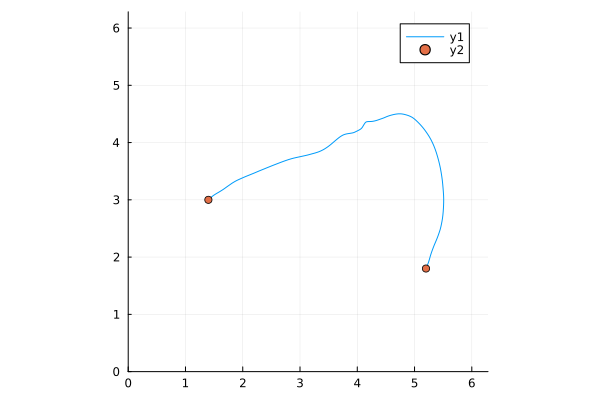

In [112]:
using OrdinaryDiffEq,
      Optimization, OptimizationPolyalgorithms, SciMLSensitivity,
      Zygote, Plots

function advection!(du, u, p, t)
    x, y, z = u
    T = p[2]
    du[1] = dx = T*velX(x,y,t*T) + V0*T*cos(z)
    du[2] = dy = T*velY(x,y,t*T) + V0*T*sin(z)
    du[3] = dz = T*(velY_x(x,y,t*T)*sin(z)*sin(z) - velX_y(x,y,t*T)*cos(z)*cos(z) + sin(z)*cos(z)*(velX_x(x,y,t*T)-velY_y(x,y,t*T)))
end

# Simulation interval and intermediary points
tspan = (0.0, 1.0)
tsteps = 0.0:0.001:1.0

# System parameters (initial guess)
p = [0.2259708, 0.81]
#p = [-0.030187, 0.81]
#p = [-0.620095, 1.08]

u0 = [xA, yA, p[1]]

# Setup the ODE problem, then solve
prob = ODEProblem(advection!, u0, tspan, p)
sol = solve(prob, Tsit5(), reltol = 1e-12, abstol = 1e-12)

# Plot the solution
using Plots
plot(t->sol(t)[1], t->sol(t)[2], 0, 1, xlim=(0, L), ylim=(0, L), aspect_ratio=:equal)
scatter!([xA, xB], [yA, yB])

In [113]:
# Loss function to be minimized
function loss(p)
    prob = ODEProblem(advection!, [xA, yA, p[1]], tspan, p)
    sol = solve(prob, Tsit5(), p = p, saveat = tsteps, reltol = 1e-12, abstol = 1e-12)
    loss = (sol[end][1]-xB)^2 + (sol[end][2]-yB)^2
    return loss
end

# display value of loss during optimization
callback = function (state, l)
    if (state.iter % 100) == 0
        println("loss=", l)
    end
    return false
end

adtype = Optimization.AutoZygote()
optf = Optimization.OptimizationFunction((x, p) -> loss(x), adtype)
optprob = Optimization.OptimizationProblem(optf, p)

result_ode = Optimization.solve(optprob, PolyOpt(),
    callback = callback, reltol = 1e-8, abstol = 1e-8,
    maxiters = 300)

loss=33.10147852024367
loss=44.06776797094452
loss=43.937538254087755
loss=0.00011689217857448726
loss=0.00011689217857448726


retcode: Success
u: 2-element Vector{Float64}:
 0.22597081806374683
 0.8099999756285967

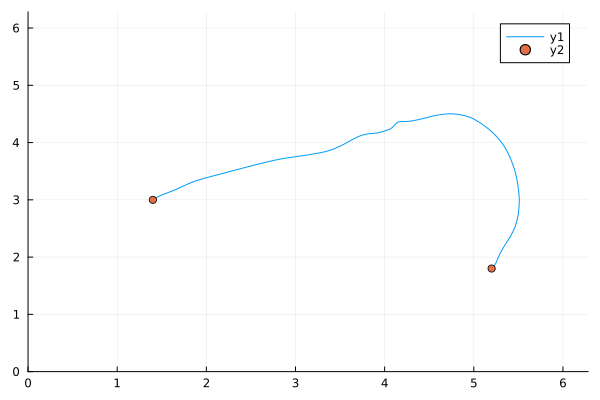

In [114]:
# optimal control solution:
p_opt = result_ode.u
prob_opt = ODEProblem(advection!, [xA, yA, p_opt[1]], tspan, p_opt)
opt_solution = solve(prob_opt, Tsit5(), p = p_opt, saveat = tsteps, reltol = 1e-12, abstol = 1e-12)

plot(t->opt_solution(t)[1], t->opt_solution(t)[2], 0, 1, xlim=(0, L), ylim=(0, L))
scatter!([xA, xB], [yA, yB])

### Optimal Trajectory + Perturbations (Noise)

In [115]:
# generating trajectories with noisy initial control
ϵ = (pi/180)/50

p1 = [result_ode.u[1]+ϵ, result_ode.u[2]]
prob_p1 = ODEProblem(advection!, [xA, yA, p1[1]], tspan, p1)
p1_solution = solve(prob_p1, Tsit5(), p = p1, saveat = tsteps, reltol = 1e-12, abstol = 1e-12)

p2 = [result_ode.u[1]-ϵ, result_ode.u[2]]
prob_p2 = ODEProblem(advection!, [xA, yA, p2[1]], tspan, p2)
p2_solution = solve(prob_p2, Tsit5(), p = p2, saveat = tsteps, reltol = 1e-12, abstol = 1e-12)

# generating trajectories with noisy start position
Δ = 1e-3

prob_p3 = ODEProblem(advection!, [xA+Δ, yA, p_opt[1]], tspan, p_opt)
p3_solution = solve(prob_p3, Tsit5(), p = p_opt, saveat = tsteps, reltol = 1e-12, abstol = 1e-12)

prob_p4 = ODEProblem(advection!, [xA, yA+Δ, p_opt[1]], tspan, p_opt)
p4_solution = solve(prob_p4, Tsit5(), p = p_opt, saveat = tsteps, reltol = 1e-12, abstol = 1e-12)

nothing

In [116]:
# array for all tracks
x_tracks = []
y_tracks = []

# points for separate tracks
x1_points = []
y1_points = []

x2_points = []
y2_points = []

x3_points = []
y3_points = []

x4_points = []
y4_points = []

x0_points = []
y0_points = []

T = p_opt[2]
Δt = T/240

for i in 1:240
    x0_now, y0_now = opt_solution(i*Δt/T)[1], opt_solution(i*Δt/T)[2]
    push!(x0_points, x0_now)
    push!(y0_points, y0_now)

    x1_now, y1_now =p1_solution(i*Δt/T)[1], p1_solution(i*Δt/T)[2]
    push!(x1_points, x1_now)
    push!(y1_points, y1_now)

    x2_now, y2_now = p2_solution(i*Δt/T)[1], p2_solution(i*Δt/T)[2]
    push!(x2_points, x2_now)
    push!(y2_points, y2_now)

    x3_now, y3_now = p3_solution(i*Δt/T)[1], p3_solution(i*Δt/T)[2]
    push!(x3_points, x3_now)
    push!(y3_points, y3_now)

    x4_now, y4_now = p4_solution(i*Δt/T)[1], p4_solution(i*Δt/T)[2]
    push!(x4_points, x4_now)
    push!(y4_points, y4_now)
end

push!(x_tracks, x1_points)
push!(y_tracks, y1_points)

push!(x_tracks, x2_points)
push!(y_tracks, y2_points)

push!(x_tracks, x3_points)
push!(y_tracks, y3_points)

push!(x_tracks, x4_points)
push!(y_tracks, y4_points)

push!(x_tracks, x0_points)
push!(y_tracks, y0_points)   

nothing

i = 60
i = 120
i = 180
i = 240


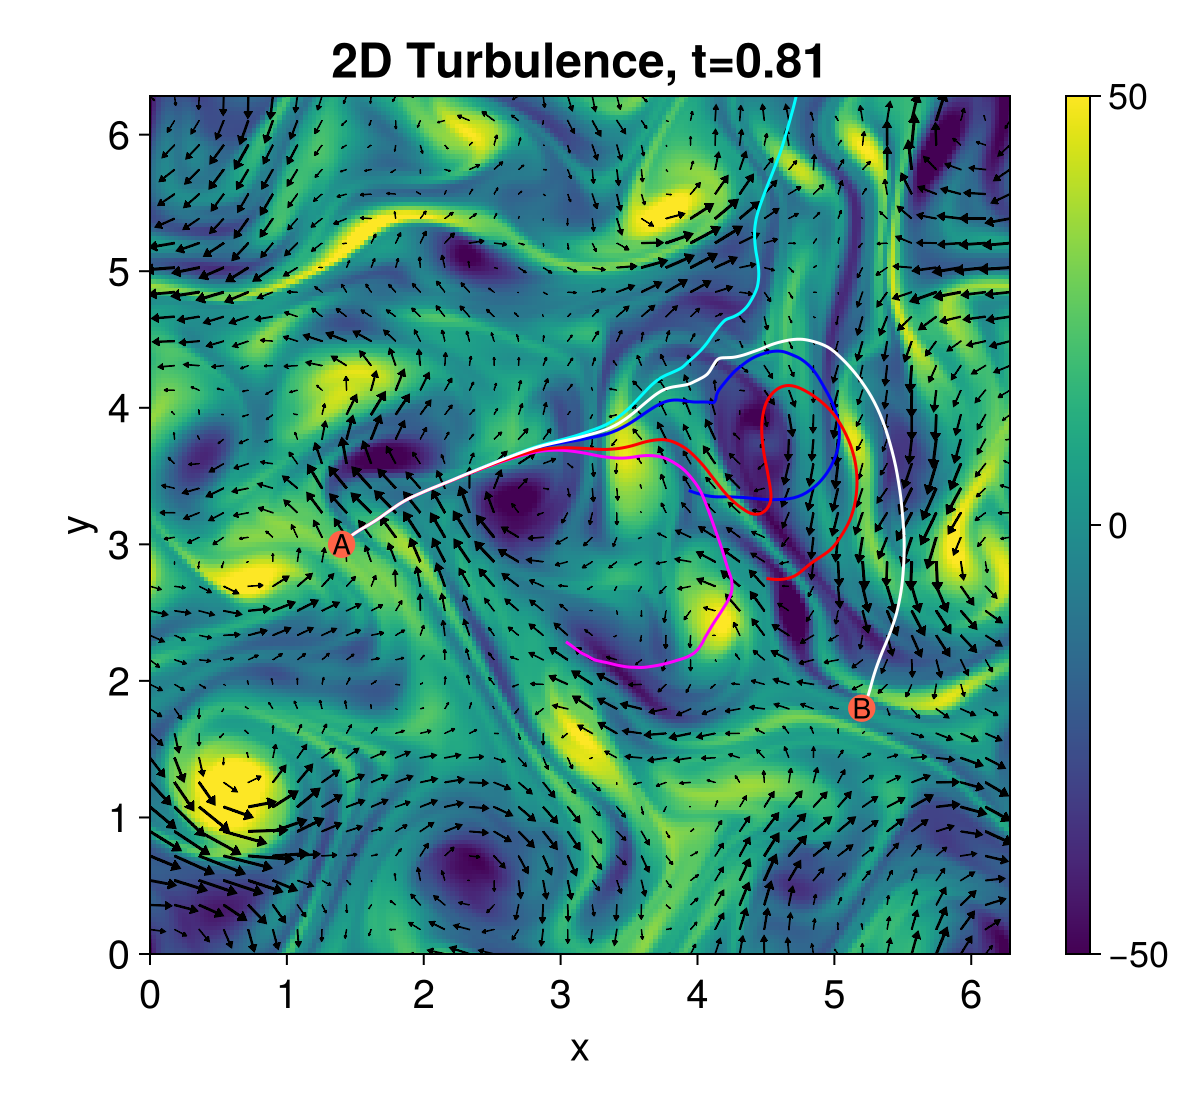

In [117]:
using CairoMakie, Printf

Δt = T/240

frame = Observable(1)
tau = @lift($frame*Δt)

xs = range(0, L, length=200)
ys = range(0, L, length=200)
zs = @lift([vort(x,y, $tau) for x in xs, y in ys])

xs2 = LinRange(0, L, 36)
ys2 = LinRange(0, L, 36)
us2 = @lift([velX(x,y, $tau) for x in xs2, y in ys2])
vs2 = @lift([velY(x,y, $tau) for x in xs2, y in ys2])

points_list = Any[]

for p in 1:5
    points = Observable(Point2f[(xA, yA)])
    push!(points_list, points)
end


fig = Figure(size = (600, 550))

ax = Axis(fig[1, 1],
    title = @lift("2D Turbulence, t="*@sprintf("%.2f", $tau)), titlesize=24,
    xlabel = "x", xlabelsize=20, xticklabelsize=20,
    ylabel = "y", ylabelsize=20, yticklabelsize=20,
    aspect = 1, limits = ((0, L), (0, L))
)

hm = CairoMakie.heatmap!(ax, xs, ys, zs, colormap = :viridis, alpha=1.0, colorrange=(-50, 50))
Colorbar(fig[:, end+1], hm, ticklabelsize=18)

arrows2d!(ax, xs2, ys2, us2, vs2, lengthscale = 0.02, tiplength=4, tipwidth=6,
            shaftwidth=1.5)

lines!(ax, points_list[1], color=:cyan)
lines!(ax, points_list[2], color=:blue)
lines!(ax, points_list[3], color=:magenta)
lines!(ax, points_list[4], color=:red)
lines!(ax, points_list[5], color=:white)
    
poly!(ax, Circle(Point2f(xA, yA), 0.1), color = :tomato)
text!(xA, yA, text = "A", align = (:center, :center))

poly!(ax, Circle(Point2f(xB, yB), 0.1), color = :tomato)
text!(xB, yB, text = "B", align = (:center, :center))


frames = 1:240

record(fig, "2d-turb-time.mp4", frames; framerate = 20) do i
    mod(i, 60) == 0 && @show i
    frame[] = i

    for (idx, points) in enumerate(points_list)
        new_point = Point2f(x_tracks[idx][i], y_tracks[idx][i])
        points[] = push!(points[], new_point)
    end
end

save("2d-turb-time.pdf", fig)
fig

# Lyapunov Exponents

In [122]:
dS = [1e-7, 1e-7, 1e-7]  #[dx,dy,dθ]

# Simulation interval and intermediary points
tspan = (0.0, 1.0)
tsteps = 0.0:0.001:1.0

p_opt = [0.22597081806374683, 0.8099999756285967]
prob_opt = ODEProblem(advection!, [xA, yA, p_opt[1]], tspan, p_opt)
opt_solution = solve(prob_opt, p = p_opt, saveat = tsteps, reltol = 1e-16, abstol = 1e-16)

# perturbed solutions
prob_S1 = ODEProblem(advection!, [xA+dS[1], yA, p_opt[1]], tspan, p_opt)
pS1_solution = solve(prob_S1, p = p_opt, saveat = tsteps, reltol = 1e-16, abstol = 1e-16)

prob_S2 = ODEProblem(advection!, [xA, yA+dS[2], p_opt[1]], tspan, p_opt)
pS2_solution = solve(prob_S2, p = p_opt, saveat = tsteps, reltol = 1e-16, abstol = 1e-16)

p_dS = [p_opt[1]+dS[3], p_opt[2]]
prob_S3 = ODEProblem(advection!, [xA, yA, p_dS[1]], tspan, p_dS)
pS3_solution = solve(prob_S3, p = p_dS, saveat = tsteps, reltol = 1e-16, abstol = 1e-16)

nothing

In [123]:
times = range(0, 1, length=100)
T = p_opt[2]

# construction of matrix W from perturbed solutions
W11 = [(pS1_solution(t)[1] - opt_solution(t)[1])/dS[1] for t in times]
W21 = [(pS1_solution(t)[2] - opt_solution(t)[2])/dS[1] for t in times]
W31 = [(pS1_solution(t)[3] - opt_solution(t)[3])/dS[1] for t in times]

W12 = [(pS2_solution(t)[1] - opt_solution(t)[1])/dS[2] for t in times]
W22 = [(pS2_solution(t)[2] - opt_solution(t)[2])/dS[2] for t in times]
W32 = [(pS2_solution(t)[3] - opt_solution(t)[3])/dS[2] for t in times]

W13 = [(pS3_solution(t)[1] - opt_solution(t)[1])/dS[3] for t in times]
W23 = [(pS3_solution(t)[2] - opt_solution(t)[2])/dS[3] for t in times]
W33 = [(pS3_solution(t)[3] - opt_solution(t)[3])/dS[3] for t in times]

nothing

In [124]:
using LinearAlgebra

l1 = zeros(100)
l2 = zeros(100)
l3 = zeros(100)

# calculation of Lyapunov exponents 
for i in 1:100
    W = [W11[i] W12[i] W13[i]; W21[i] W22[i] W23[i]; W31[i] W32[i] W33[i]]
    l1[i], l2[i], l3[i] = log.(svdvals(W))/(times[i])
end

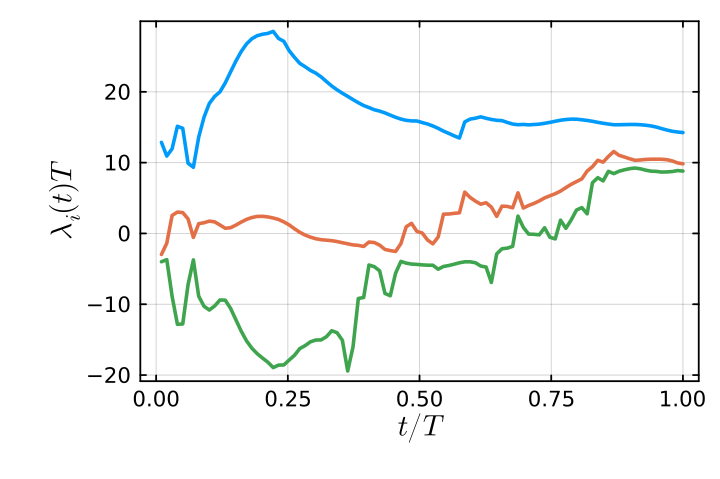

In [125]:
using LaTeXStrings

p = plot(times, [l1, l2, l3], framestyle=:box, lw=2, xlabel=L"t/T", ylabel=L"\lambda_i(t)T",
    legend=false, dpi=120, thickness_scaling=1.5)

savefig(p, "2d-turb-time FTLE.pdf")
p